In [1]:
import pandas as pd
import time
import re
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
from statsmodels.graphics.regressionplots import abline_plot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV



In [2]:
df_wnba=pd.read_pickle('pickles/df_wnba')
df_wnba_pg=pd.read_pickle('pickles/df_wnba_pg')
df_wnba_adv=pd.read_pickle('pickles/df_wnba_adv')
df_allstar=pd.read_csv('pickles/allstar.csv')
df_draft = pd.read_csv('pickles/draft.csv')
salary=pd.read_pickle('pickles/salary')


In [3]:
df_stats1=pd.merge(left=df_wnba, right=df_wnba_pg, on = ['Player','Year'], #928 rows × 44 columns
            suffixes=('', 'pg'))
df_stats2=pd.merge(left=df_stats1, right=df_wnba_adv, on = ['Player','Year'], #928 rows × 75 columns
            suffixes=('', 'adv'))
df_stats3=pd.merge(left=df_stats2, right=df_allstar, how='left',on = ['Player','Year'])
df_stats=pd.merge(left=df_stats3, right=df_draft, how='left',on = ['Player'],suffixes=('', 'draft'))
df_stats.columns

Index(['Player', 'Team', 'Pos', 'G', 'MP', 'GS', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year', 'Teampg', 'Pospg',
       'Gpg', 'MPpg', 'GSpg', 'FGpg', 'FGApg', 'FG%pg', '3Ppg', '3PApg',
       '3P%pg', '2Ppg', '2PApg', '2P%pg', 'FTpg', 'FTApg', 'FT%pg', 'ORBpg',
       'TRBpg', 'ASTpg', 'STLpg', 'BLKpg', 'TOVpg', 'PFpg', 'PTSpg', 'Teamadv',
       'Posadv', 'Gadv', 'MPadv', 'PER', 'TS%', 'eFG%', '3PAr', 'FTr', 'ORB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'ORtg', 'DRtg', 'OWS',
       'DWS', 'WS', 'WS/40', 'AllStar', 'TTLAllStar', 'Yeardraft', 'Pick'],
      dtype='object')

In [8]:
df_stats[(df_stats.Player =='Rebecca Allen')]
#df_allstar[(df_allstar.Player == 'Diana Taurasi')&(df_allstar.Year == 2021)]
#df_stats[(df_stats.Player == 'Diana Taurasi')&(df_allstar.Year == 2021)]#

,Player,Team,Pos,G,MP,GS,FG,FGA,FG%,3P,...,ORtg,DRtg,OWS,DWS,WS,WS/40,AllStar,TTLAllStar,Yeardraft,Pick
3,Rebecca Allen,NYL,F,25,615,13,74,216,0.343,48,...,97.0,101.0,0.3,0.9,1.2,0.075,NaN,NaN,2015.0,NaN
302,Rebecca Allen,NYL,F,24,412,2,65,156,0.417,29,...,101.0,107.0,0.5,0.2,0.6,0.059,NaN,NaN,2015.0,NaN
460,Rebecca Allen,NYL,F,28,291,0,38,101,0.376,10,...,92.0,108.0,-0.2,0.3,0.1,0.011,NaN,NaN,2015.0,NaN
622,Rebecca Allen,NYL,F,33,304,0,38,101,0.376,15,...,90.0,95.0,-0.2,0.7,0.5,0.070,NaN,NaN,2015.0,NaN
778,Rebecca Allen,NYL,F,21,280,6,45,98,0.459,17,...,110.0,102.0,0.5,0.4,0.9,0.134,NaN,NaN,2015.0,NaN


In [252]:
salary[(salary.Player =='Rebecca Allen')]

,Player,base,Year,salary
57,Rebecca Allen,105037,2021,105037.0
222,Rebecca Allen,81600,2020,80800.0
395,Rebecca Allen,80000,2019,80800.0
538,Rebecca Allen,56100,2018,56100.0


<AxesSubplot:xlabel='Year'>

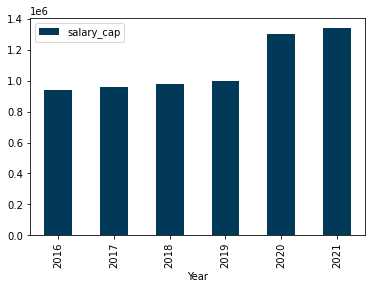

In [4]:
#salary cap table from https://herhoopstats.com/wnba_cba_salary_cap_explained
#2016 and 2017 did not have a salary cap in operation, so assumption was used

salary_cap = {
    2016: 942489,
    2017: 959394,
    2018: 976300,
    2019: 996100,
    2020: 1300000,
    2021: 1339000
}
df_cap= pd.DataFrame(salary_cap.items(),columns=['Year','salary_cap'])
df_cap

df_cap.plot(kind='bar' , x='Year',cmap='PuBu_r')

In [5]:
#merge stats with salaries and yearly max cap info

df=pd.merge(left=df_stats, right=salary,
            how='inner',
            left_on=['Player','Year'], 
            right_on=['Player','Year'])
df=pd.merge(left=df, right = df_cap,
            how='inner',
            on=['Year'])


In [6]:
#calculate salary as a % of cap
df['%CAP']= df['salary']/df['salary_cap'] 

#calculate number of years in the league
df['years_active']= df['Year']- df['Yeardraft']+1 #they play in the year they were drafted so add one


In [7]:

#columns to keep for smaller dataframe
df=df[['Year','Player','Team' ,'Pos','G', 'MP', 'GS', 'FG%', '3P%',  '2P%',  'FT%', #overall game metrics
    'MPpg', 'FGpg','3Ppg', '2Ppg', 'FTpg', 'TRBpg', 'ASTpg', 'STLpg', 'BLKpg',  'PFpg', 'PTSpg', #pergame metrics
    'PER','TS%','eFG%', '3PAr', 'FTr','USG%', 'ORtg', 'DRtg', 'WS', 'AllStar','TTLAllStar','years_active','Pick',#advanced metrics
    'salary','salary_cap','%CAP']]# target

#drop players who didn't play any minutes all season
df = df[df.MP != 0]

In [9]:
df.groupby('Year').count()['Player'] #544 x 48  
df.shape

(544, 38)

In [10]:
#if they weren't drafted, set Pick as 65 (max draft number is 64)
df.Pick.fillna(65,inplace=True)
#if they didn't play or didn't score, the field is NA - NA should be set to zero
df.fillna(0,inplace=True)
np.isnan(df[['G', 'MP', 'GS', 'FG%', '3P%',  '2P%',  'FT%', #overall game metrics
    'MPpg', 'FGpg','3Ppg', '2Ppg', 'FTpg', 'TRBpg', 'ASTpg', 'STLpg', 'BLKpg',  'PFpg', 'PTSpg', #pergame metrics
    'PER','TS%','eFG%', '3PAr', 'FTr','USG%', 'ORtg', 'DRtg', 'WS', 'AllStar','TTLAllStar','years_active','Pick',#advanced metrics
    '%CAP']]).sum() #check infinities

G               0
MP              0
GS              0
FG%             0
3P%             0
2P%             0
FT%             0
MPpg            0
FGpg            0
3Ppg            0
2Ppg            0
FTpg            0
TRBpg           0
ASTpg           0
STLpg           0
BLKpg           0
PFpg            0
PTSpg           0
PER             0
TS%             0
eFG%            0
3PAr            0
FTr             0
USG%            0
ORtg            0
DRtg            0
WS              0
AllStar         0
TTLAllStar      0
years_active    0
Pick            0
%CAP            0
dtype: int64

In [60]:
df.corr()

,Year,G,MP,GS,FG%,3P%,2P%,FT%,MPpg,FGpg,...,USG%,ORtg,DRtg,WS,AllStar,TTLAllStar,years_active,Pick,salary_cap,%CAP
Year,1.000000,-0.314300,-0.178610,-0.132318,-0.064660,0.010935,-0.049122,-0.063323,-0.178610,-0.055179,...,-0.051678,-0.112699,-0.061965,-0.164323,-0.089617,-0.069519,0.025388,0.048526,0.902272,-0.119892
G,-0.314300,1.000000,0.763774,0.533164,0.274118,0.125510,0.216128,0.351647,0.763774,0.335609,...,0.122129,0.331145,-0.133924,0.445998,0.178198,0.044700,0.068218,-0.114858,-0.399760,0.190340
MP,-0.178610,0.763774,1.000000,0.886620,0.332902,0.218391,0.296753,0.396286,1.000000,0.756783,...,0.368191,0.423595,-0.126693,0.714610,0.391920,0.258858,0.259434,-0.226184,-0.210276,0.435635
GS,-0.132318,0.533164,0.886620,1.000000,0.308348,0.174899,0.275182,0.315630,0.886620,0.742385,...,0.332368,0.381559,-0.127663,0.689333,0.395005,0.316660,0.311351,-0.223083,-0.143901,0.471604
FG%,-0.064660,0.274118,0.332902,0.308348,1.000000,0.063658,0.838788,0.291677,0.332902,0.472100,...,0.202660,0.806514,-0.235129,0.507502,0.180814,0.164745,0.132212,-0.168786,-0.021966,0.181984
3P%,0.010935,0.125510,0.218391,0.174899,0.063658,1.000000,0.017227,0.283434,0.218391,0.240692,...,0.234057,0.298129,0.102694,0.142997,0.120861,0.091725,0.100224,-0.003446,0.039307,0.144403
2P%,-0.049122,0.216128,0.296753,0.275182,0.838788,0.017227,1.000000,0.281999,0.296753,0.413075,...,0.178441,0.668954,-0.148307,0.439342,0.172291,0.155011,0.126581,-0.149285,-0.008545,0.162482
FT%,-0.063323,0.351647,0.396286,0.315630,0.291677,0.283434,0.281999,1.000000,0.396286,0.384377,...,0.364311,0.506952,0.030919,0.265727,0.139463,0.143350,0.136348,-0.054523,-0.046775,0.218317
MPpg,-0.178610,0.763774,1.000000,0.886620,0.332902,0.218391,0.296753,0.396286,1.000000,0.756783,...,0.368191,0.423595,-0.126693,0.714610,0.391920,0.258858,0.259434,-0.226184,-0.210276,0.435635
FGpg,-0.055179,0.335609,0.756783,0.742385,0.472100,0.240692,0.413075,0.384377,0.756783,1.000000,...,0.712098,0.490707,-0.152158,0.743852,0.526970,0.393784,0.270314,-0.319082,-0.005163,0.515736


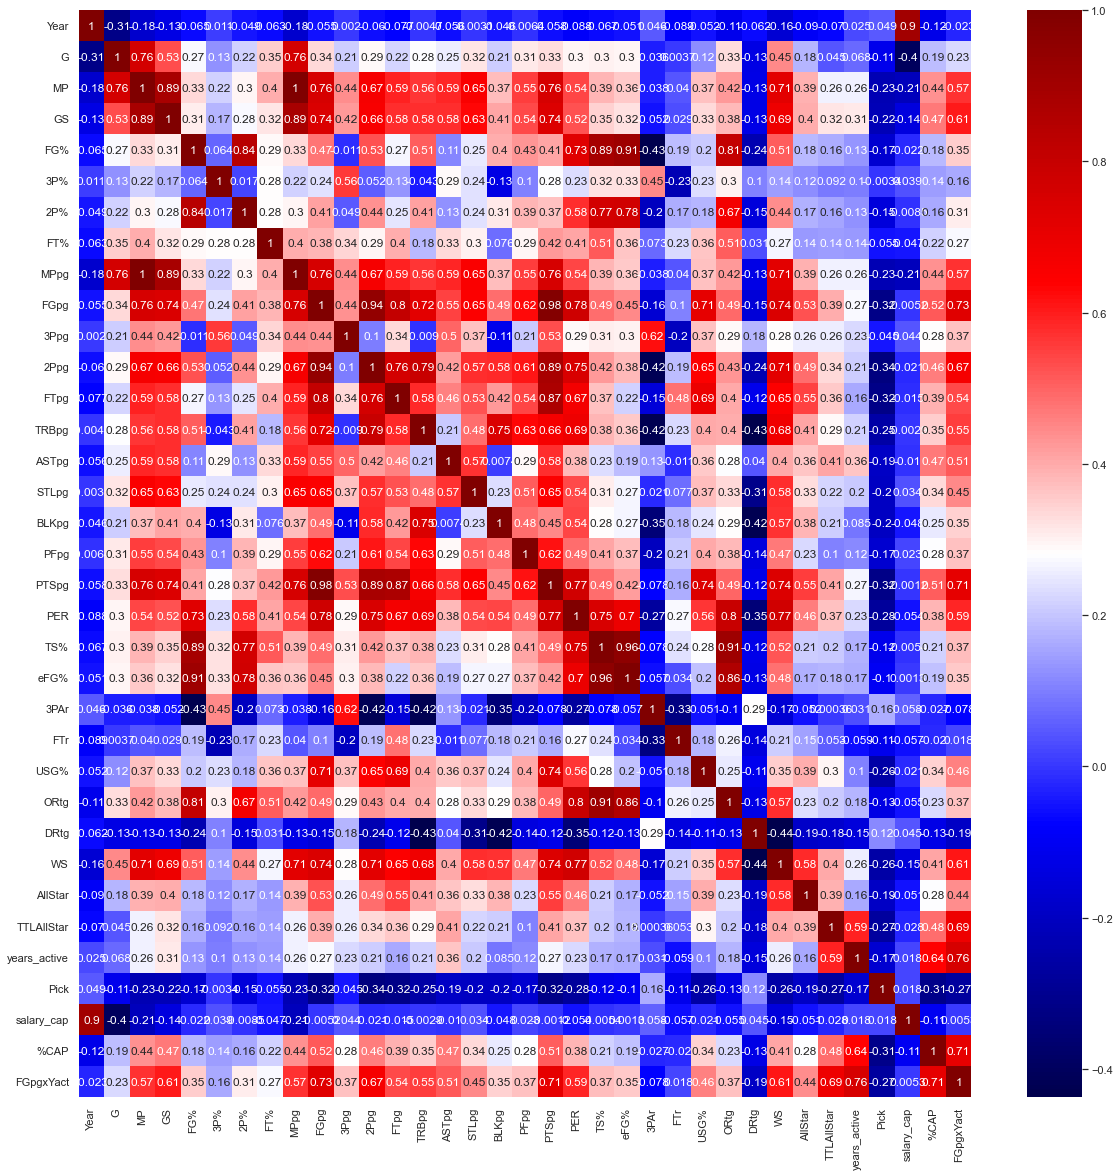

In [72]:
#visualize correlations
sns.heatmap(df.corr(), cmap="seismic",annot=True)
sns.set(rc = {'figure.figsize':(20,20)})

In [47]:
corr=pd.DataFrame(df.corr()['%CAP'].sort_values(ascending= False))
corr.head(11)

,%CAP
%CAP,1.000000
salary,0.949707
prediction,0.738128
FGpgxYact,0.712383
years_active,0.639544
FGpg,0.515736
PTSpg,0.509469
TTLAllStar,0.483971
GS,0.471604
ASTpg,0.468929


In [60]:
#add interactions 
df['FGpgxYact']=df['FGpg']*df['years_active']
#add interactions 
df['ASTpgxYact']=df['ASTpg']*df['years_active']

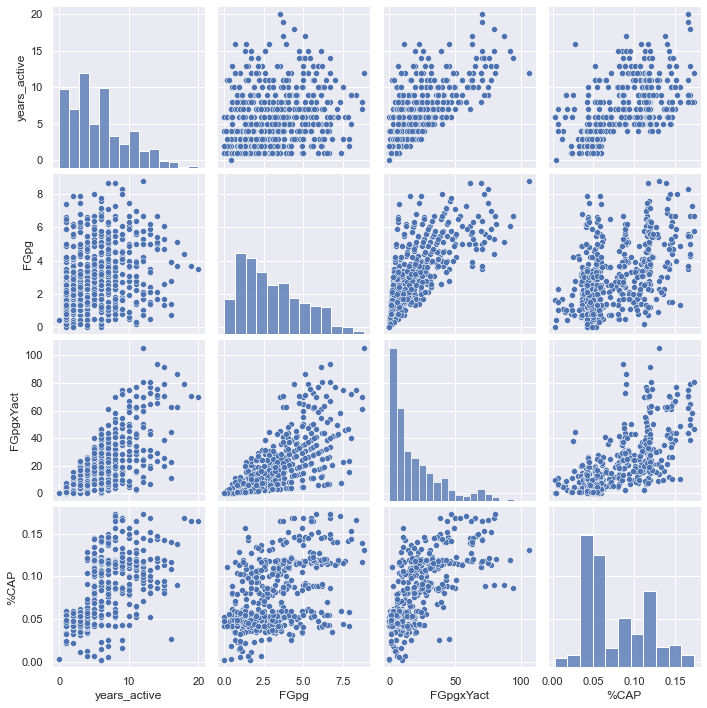

In [84]:
sns.pairplot(pd.concat([df[columns], df['%CAP']],axis=1))

In [159]:
"""
 different model versions:
# Run 1 [ 'GS','MPpg','FGpg','ASTpg'] R squared 0.3 -- first try didn't include years active, tried to minimize p-values and VIFs
# Run 2 [...All 31 features...] R squared 0.55 - lasso zeroed out everything but ASTpg, FGpg and years_active
# Run 3 [ 'GS','MPpg','FGpg','ASTpg','years_active','TTLAllstar'] R squared 0.5 -- used lasso regression same features were zeroed out as Run2
# Run 4 ['FGpg','ASTpg','years_active','FGpgxYact'] -- R squared 0.59  0.018 smallest MAE 
# Run 5 ['FGpg','ASTpg','years_active','FGpgxYact','ASTpgxYact'] -- additional interaction didn't improve results
"""

columns =['FGpg','ASTpg','years_active','FGpgxYact','ASTpgxYact']

X = df[columns]
# Choose the response variable(s)
y = df['%CAP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 88)

In [160]:
#try statsmodels first to see summary stats

#fit regression model
y=y_train
X=X_train

X =sm.add_constant(X)
model = sm.OLS(y, X).fit()

#display adjusted R-squared
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   %CAP   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     18.42
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           4.19e-58
Time:                        15:39:04   Log-Likelihood:                 995.09
No. Observations:                 435   AIC:                            -1928.
Df Residuals:                     404   BIC:                            -1802.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0104      0.041      0.255      0.799      -0.069       0.090
G                0.0008      0.000      1.903      0.058   -2.49e-05       0.002
MP           -2.194e-05   1.04e-05     -2.101      0.036   -4.25e-05   -1.41e-06
GS               0.0005      0.000      1.930      0.054   -9.53e-06       0.001
FG%              0.0375      0.163      0.230      0.819      -0.284       0.359
3P%              0.0086      0.011      0.785      0.433      -0.013       0.030
2P%             -0.0064      0.031     -0.208      0.835      -0.066       0.054
FT%             -0.0153      0.012     -1.299      0.195      -0.039       0.008
MPpg         -2.194e-05   1.04e-05     -2.101      0.036   -4.25e-05   -1.41e-06
FGpg            -0.0237      0.039     -0.605      0.545      -0.101       0.053
3Ppg             0.0070      0.035      0.201      0.841      -0.061       0.075
2Ppg             0.0154      0.027      0.569      0.570      -0.038       0.069
FTpg            -0.0112      0.017     -0.660      0.510      -0.045       0.022
TRBpg           -0.0010      0.001     -0.832      0.406      -0.003       0.001
ASTpg            0.0044      0.001      3.365      0.001       0.002       0.007
STLpg            0.0011      0.005      0.221      0.826      -0.008       0.011
BLKpg            0.0140      0.005      2.902      0.004       0.005       0.023
PFpg            -0.0028      0.003     -1.005      0.315      -0.008       0.003
PTSpg            0.0076      0.017      0.456      0.649      -0.025       0.041
PER             -0.0006      0.001     -0.721      0.472      -0.002       0.001
TS%              0.1334      0.119      1.124      0.262      -0.100       0.367
eFG%            -0.1901      0.169     -1.126      0.261      -0.522       0.142
3PAr             0.0052      0.022      0.240      0.811      -0.037       0.048
FTr             -0.0154      0.019     -0.829      0.408      -0.052       0.021
USG%             0.0009      0.001      1.651      0.099      -0.000       0.002
ORtg             0.0001      0.000      0.422      0.673      -0.000       0.001
DRtg             0.0001      0.000      0.413      0.680      -0.001       0.001
WS               0.0028      0.002      1.339      0.181      -0.001       0.007
AllStar         -0.0060      0.006     -0.982      0.327      -0.018       0.006
TTLAllStar      -0.0004      0.001     -0.840      0.401      -0.001       0.001
years_active     0.0050      0.000     12.372      0.000       0.004       0.006
Pick            -0.0003   9.17e-05     -3.243      0.001      -0.000      -0.000
==============================================================================
Omnibus:                        5.967   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                7.961
Skew:      

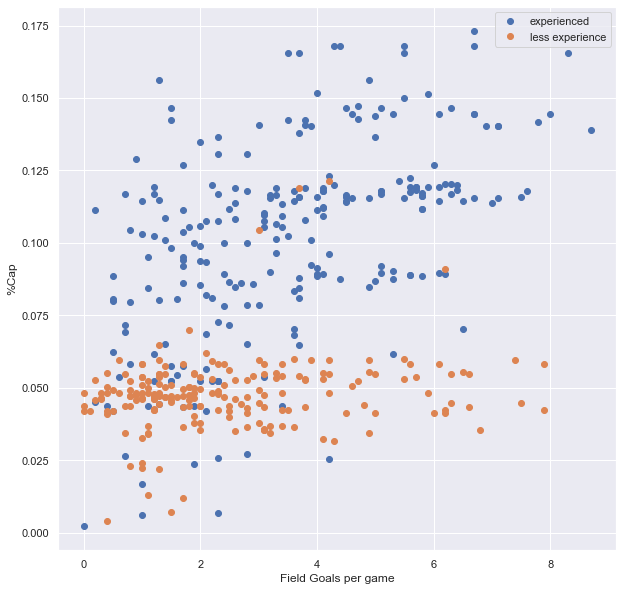

In [146]:
#check for interactions
df_int=pd.DataFrame(pd.concat([X_train,y_train],axis=1))

#df_int.years_active.median() #5 years
df_int['experienced'] = 'experienced'
df_int.loc[df_int['years_active'] <5, 'experienced'] = 'less experience'

groups = df_int.groupby("experienced")
for name, group in groups:
    plt.plot(group["FGpg"], group["%CAP"], marker="o", linestyle="", label=name)
plt.legend()
plt.xlabel('Field Goals per game')
plt.ylabel('%Cap')

sns.set(rc = {'figure.figsize':(10,10)})
plt.show()


In [147]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = model.model.exog  
vif=[variance_inflation_factor(variables,i)
        for i in range (variables.shape[1])]

inputs = y_names = ['salary'] + columns
vif_output = pd.DataFrame(np.column_stack([inputs,vif]), 
                               columns=['input','vif' ])
vif_output

,input,vif
0,salary,9.737018509129115
1,FGpg,5.343838517908162
2,ASTpg,6.267808257921371
3,years_active,4.463874116838952
4,FGpgxYact,9.830966760876198
5,ASTpgxYact,9.769768849800327


In [148]:

lm = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 88
     ) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv = cross_val_score(lm,X_train,y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print(lm_cv)

# to print the mean score with standard deviation, rounded to 2 decimals
print(np.round(np.mean(lm_cv), 2), "+-", np.round(np.std(lm_cv),2))


[0.42025561 0.57828663 0.62499858 0.43159278 0.52649152]
0.52 +- 0.08


In [149]:
lg_model=lm.fit(X_train, y_train)
train_score = lm.score(X_train, y_train)
print(train_score)
print(lg_model.coef_)


0.5436452036342885
[ 2.35481358e-03  3.54356910e-03  3.34377044e-03  5.68637595e-04
 -9.18948055e-05]


In [150]:
#try polynomial features
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit a model using polynomial features
lr_poly = LinearRegression()

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 88
     ) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv = cross_val_score(lr_poly,X_train_poly,y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print(lm_cv)

# to print the mean score with standard deviation, rounded to 2 decimals
print(np.round(np.mean(lm_cv), 2), "+-", np.round(np.std(lm_cv),2))


[0.53135805 0.5976415  0.62143762 0.5170498  0.58515668]
0.57 +- 0.04


In [151]:

poly_model=lr_poly.fit(X_train_poly, y_train)
train_score = lr_poly.score(X_train_poly, y_train)
print(train_score)

#polynomials improved performance slightly

0.6110182456133387


In [152]:
poly.get_feature_names_out()

array(['1', 'FGpg', 'ASTpg', 'years_active', 'FGpgxYact', 'ASTpgxYact',
       'FGpg^2', 'FGpg ASTpg', 'FGpg years_active', 'FGpg FGpgxYact',
       'FGpg ASTpgxYact', 'ASTpg^2', 'ASTpg years_active',
       'ASTpg FGpgxYact', 'ASTpg ASTpgxYact', 'years_active^2',
       'years_active FGpgxYact', 'years_active ASTpgxYact', 'FGpgxYact^2',
       'FGpgxYact ASTpgxYact', 'ASTpgxYact^2'], dtype=object)

In [153]:
#scale data for ridge /lasso regression 

from sklearn.preprocessing import StandardScaler
## .fit finds the mean and standard deviation of each variable in the training set
std = StandardScaler()
std.fit(X_train_poly)
## apply the scaler to the train set - assists vs GS will be on very different scales
X_tr = std.transform(X_train_poly)


In [154]:
#scale data for ridge /lasso regression 

from sklearn.preprocessing import StandardScaler
## .fit finds the mean and standard deviation of each variable in the training set
std = StandardScaler()
std.fit(X_train.values)
## apply the scaler to the train set - assists vs GS will be on very different scales
X_tr = std.transform(X_train.values)
## Apply the scaler to the test set
X_te = std.transform(X_test.values)


In [155]:
#Ridge model

#optimize alpha by iterating
alphas = 10**np.linspace(-2,2,200)
ridge_model = RidgeCV(alphas = alphas, cv=5)
ridge_model.fit(X_tr, y_train)
alpha = ridge_model.alpha_

print(alpha)

#refit model with optimized alpha
ridge_model = Ridge(alpha =alpha)
ridge_model.fit(X_tr, y_train)

print(list(zip(X_train.columns, ridge_model.coef_)))
print(ridge_model.score(X_tr, y_train))



28.660676169482503
[('FGpg', 0.005501034161027201), ('ASTpg', 0.003477678471973342), ('years_active', 0.012001520624698774), ('FGpgxYact', 0.009926897646181466), ('ASTpgxYact', 0.0018165689817651596)]
0.5422536223147321


In [156]:
#Lasso Model

#optimize alpha by iterating
alphavec = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)
alpha = lasso_model.alpha_
print(alpha)

## refit LASSO model with optimized alpha
lasso_model = Lasso(alpha =alpha)
lasso_model.fit(X_tr,y_train)

print(list(zip(X_train.columns, lasso_model.coef_)))
print(lasso_model.score(X_tr, y_train))

# keeps suggesting very small lambda.. 
# maybe a zero coefficient can be found without penalty on the likelihood

#keeps 
#['FGpg','ASTpg','years_active','FGpgxASTpg']

0.01
[('FGpg', 0.0), ('ASTpg', 0.0), ('years_active', 0.003583026691315056), ('FGpgxYact', 0.01392469345469485), ('ASTpgxYact', 0.0)]
0.44267180164162123


In [157]:
#final test on all models
print('Simple Linear Train Score: ', lg_model.score(X_train, y_train))
print('Simple Linear Test Score: ', lg_model.score(X_test, y_test))

print('Poly Train Score: ', poly_model.score(X_train_poly, y_train))
print('Poly Test Score: ', poly_model.score(X_test_poly, y_test))
print('Ridge Train Score: ',ridge_model.score(X_tr, y_train))
print('Ridge Test Score: ', ridge_model.score(X_te, y_test))

print('Lasso Train Score: ',lasso_model.score(X_tr, y_train))
print('Lasso Test Score: ',lasso_model.score(X_te, y_test))
 


Simple Linear Train Score:  0.5436452036342885
Simple Linear Test Score:  0.5876749535768899
Poly Train Score:  0.6110182456133387
Poly Test Score:  0.647539570244839
Ridge Train Score:  0.5422536223147321
Ridge Test Score:  0.5862593483813852
Lasso Train Score:  0.44267180164162123
Lasso Test Score:  0.46745039343108363


In [158]:
#calculate model error
y_pred_lg = lg_model.predict(X_test)
print('Simple Linear RMSE: ',np.sqrt(metrics.mean_squared_error(y_test,y_pred_lg)))
print('Simple Linear MAE: ',metrics.mean_absolute_error(y_test,y_pred_lg))
y_pred_poly = poly_model.predict(X_test_poly)
print('Poly RMSE: ',np.sqrt(metrics.mean_squared_error(y_test,y_pred_poly)))
print('Poly MAE: ',metrics.mean_absolute_error(y_test,y_pred_poly))
y_pred_ridge = ridge_model.predict(X_te)
print('Ridge RMSE: ',np.sqrt(metrics.mean_squared_error(y_test,y_pred_ridge)))
print('Ridge MAE: ',metrics.mean_absolute_error(y_test,y_pred_ridge))
y_pred_lasso = lasso_model.predict(X_te)
print('Lasso RMSE: ',np.sqrt(metrics.mean_squared_error(y_test,y_pred_lasso)))
print('Lasso MAE: ',metrics.mean_absolute_error(y_test,y_pred_lasso))

Simple Linear RMSE:  0.02429430989441861
Simple Linear MAE:  0.018356561611215644
Poly RMSE:  0.022461558775844482
Poly MAE:  0.017243287115714483
Ridge RMSE:  0.02433597809286699
Ridge MAE:  0.018334636915983873
Lasso RMSE:  0.02760989422242381
Lasso MAE:  0.02245236944758794


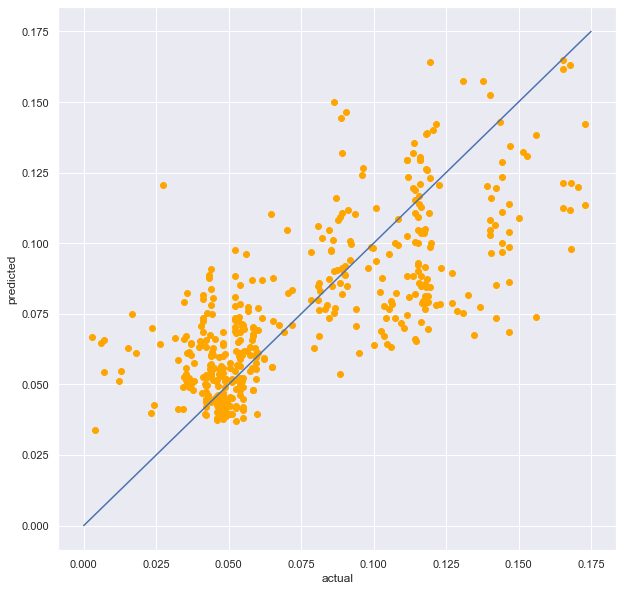

In [75]:
# Plot Fitted vs. Actual on training data
y_train_pred = lg_model.predict(X_train)

plt.scatter(y_train, y_train_pred, c='orange')
plt.plot([0, 0.175], [0, 0.175])

plt.xlabel ('actual')
plt.ylabel ('predicted')
sns.set(rc = {'figure.figsize':(10,10)})


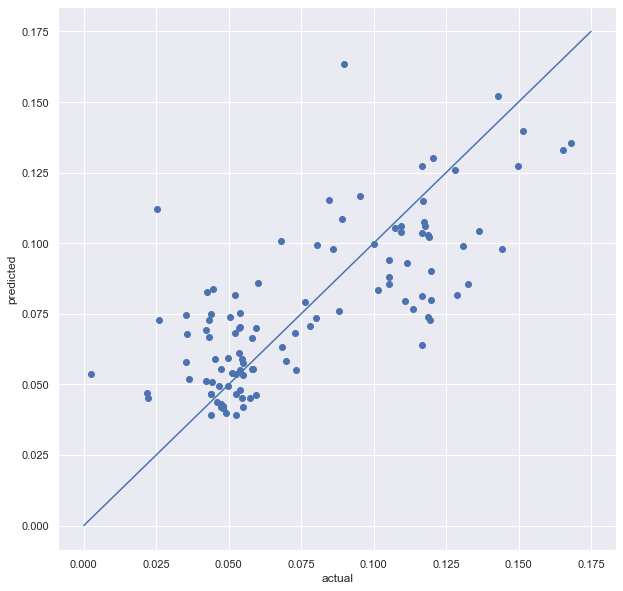

In [76]:
# Plot Fitted vs. Actual on test data
y_test_pred = lg_model.predict(X_test)

plt.scatter(y_test, y_test_pred)
plt.plot([0, 0.175], [0, 0.175])

plt.xlabel ('actual')
plt.ylabel ('predicted')
sns.set(rc = {'figure.figsize':(10,10)})

In [137]:
#create predictions
df['prediction']= lg_model.predict(df[columns])
df['residual'] = lg_model.predict(df[columns])-df['%CAP']

In [138]:
#check residuals
df.sort_values(['residual']).head()

,Year,Player,Team,Pos,G,MP,GS,FG%,3P%,2P%,...,TTLAllStar,years_active,Pick,salary,salary_cap,%CAP,FGpgxYact,ASTpgxYact,prediction,residual
110,2021,Alyssa Thomas,CON,F,3,37,0,0.267,0.000,0.267,...,0.0,8.0,4.0,209000.0,1339000,0.156087,10.4,10.4,0.073490,-0.082597
223,2020,Astou Ndour,DAL,C-F,13,151,7,0.351,0.240,0.438,...,0.0,7.0,16.0,190605.0,1300000,0.146619,10.5,3.5,0.068576,-0.078043
30,2021,Elena Delle Donne,WAS,F-G,3,52,3,0.481,0.600,0.455,...,9.0,9.0,2.0,224870.0,1339000,0.167939,38.7,6.3,0.098098,-0.069841
48,2021,Bria Hartley,PHO,G,6,51,0,0.563,0.571,0.556,...,0.0,8.0,7.0,190517.0,1339000,0.142283,12.0,6.4,0.073473,-0.068810
202,2020,Moriah Jefferson,DAL,G,9,148,6,0.409,0.333,0.421,...,0.0,5.0,2.0,175067.0,1300000,0.134667,10.0,10.0,0.067340,-0.067327


In [139]:
df.sort_values(['residual']).tail()

,Year,Player,Team,Pos,G,MP,GS,FG%,3P%,2P%,...,TTLAllStar,years_active,Pick,salary,salary_cap,%CAP,FGpgxYact,ASTpgxYact,prediction,residual
137,2021,Bria Holmes,TOT,G,19,318,5,0.323,0.242,0.365,...,0.0,6.0,11.0,3871.0,1339000,0.002891,9.6,6.6,0.066789,0.063898
36,2021,Sylvia Fowles,MIN,C,31,934,31,0.640,0.000,0.640,...,12.0,14.0,2.0,115627.0,1339000,0.086353,93.8,19.6,0.151886,0.065533
251,2020,Diana Taurasi,PHO,G,19,533,19,0.409,0.365,0.515,...,17.0,17.0,1.0,116500.0,1300000,0.089615,86.7,76.5,0.162299,0.072684
133,2021,Layshia Clarendon,TOT,G,22,543,20,0.517,0.357,0.530,...,0.0,9.0,9.0,33914.0,1339000,0.025328,37.8,48.6,0.110525,0.085197
135,2021,Candice Dupree,TOT,F,26,463,6,0.435,0.143,0.448,...,0.0,16.0,6.0,36541.0,1339000,0.027290,44.8,11.2,0.120105,0.092815


In [143]:
df.loc[df['Player']=='Liz Cambage',['Year', 'Player', 'Team', 'Pos', 'FGpg','ASTpg', 'years_active','Pick','salary',
'salary_cap','%CAP','prediction','residual']]

,Year,Player,Team,Pos,FGpg,ASTpg,years_active,Pick,salary,salary_cap,%CAP,prediction,residual
14,2021,Liz Cambage,LVA,C,5.6,1.3,11.0,2.0,221450.0,1339000,0.165385,0.121885,-0.043500
295,2019,Liz Cambage,LVA,C,6.1,2.1,9.0,2.0,114000.0,996100,0.114446,0.115425,0.000979
439,2018,Liz Cambage,DAL,C,8.7,2.3,8.0,2.0,114000.0,976300,0.116767,0.127503,0.010736


In [141]:
#Liz Cambage salary prediction salary on 2022's salary cap
0.121885*1379200

168103.792

In [277]:
check_pred=df[['Player','Year', 'Pos','residual','prediction','%CAP','salary_cap','years_active','ASTpg','FGpg','FGpgxASTpg', 'G', 'MP', 'GS', 'FG%', '3P%', '2P%',
       'FT%', 'MPpg', 'FGpg', '3Ppg', '2Ppg', 'FTpg', 'TRBpg', 'ASTpg' ,
       'STLpg', 'BLKpg', 'PFpg', 'PTSpg','years_active','TTLAllStar','Pick']]

In [278]:
check_pred.to_csv('check_pred.csv')